# Epistemic and Aleatoric Uncertainty Analysis in Neural Network with Keras for Regression Task

#### The motivation of this tutorial is to help people to understand and implement uncertainty analysis in neural network with Keras for regression task, and because there is no uncertainty analysis tutorial out there on regression task with Keras specifically. If you are doing classification task or dealing with time series data with recurrent neural net, please refer resources below. Please do not apply the methodology of this tutorial outside the scope of regression task. This tutorial ia originally technological demotration how astroNN gets its uncertainty


<br>

Here is [astroNN](https://github.com/henrysky/astroNN), please take a look if you are interested in astronomy or how neural network applied in astronomy
* **Henry W.H. Leung** - *Astronomy Undergraduate, University of Toronto* - [henrysky](https://github.com/henrysky)
* Project advisor: **Jo Bovy** - *Professor, Department of Astronomy and Astrophysics, University of Toronto* - [jobovy](https://github.com/jobovy)
* Contact Henry: [henrysky.leung@mail.utoronto.ca](mailto:henrysky.leung@mail.utoronto.ca)
* You can copy and use this tutorial freely without acknowledging me (Henry Leung), but you should acknowledge the great works and papers from **Yarin Gal (Cambridge University)**
* This tutorial is created on 09/Dec/2017 with Keras 2.1.2, Tensorflow 1.4.0, Nvidia CuDNN 6.1 for CUDA 8.0 (Optional)
 
<br>
This tutorial is based on the material, ideas and theorys from: 
* Paper: [Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](https://arxiv.org/abs/1506.02142)
* Paper: [What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?](https://arxiv.org/abs/1703.04977)
* Paper: [Bayesian Convolutional Neural Networks with Bernoulli Approximate Variational Inference](https://arxiv.org/abs/1506.02158)
* Yarin Gal's Blog: [What My Deep Model Doesn't Know...](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html)
* [Demo from Yarin Gal written in javascript](https://github.com/yaringal/HeteroscedasticDropoutUncertainty)
 
<br>
Other resources:
* If you are doing classification task: [Building a Bayesian deep learning classifier](https://github.com/kyle-dorman/bayesian-neural-network-blogpost)
* If you are doing recurrent neural net: [BayesianRNN](https://github.com/yaringal/BayesianRNN)
* If you interested in industrial application of this method: [Uber](https://eng.uber.com/neural-networks-uncertainty-estimation/)

Import everything we need

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
import random

from keras.layers import Dense
from keras.models import Model, Sequential, Input
from keras.layers import Dense, InputLayer, Dropout, Activation, regularizers
from keras import initializers
from keras.optimizers import Adam
from keras.backend import learning_phase, function
import keras.backend as K

# To get plot_model works, you need to install graphviz and pydot_ng
from keras.utils import plot_model

Using TensorFlow backend.


The equation we use neural net to do regression is
$y=0.1+0.3x+0.4x^{2}$

In [2]:
def gen_function(x):
    return(0.1+0.3*x+0.4*x**2)

#### Here, we will generate data with the regression task

Genereate data with four different region to simulate different situation
* 0.0 to 0.3, Data with random normal noise centered at 0.0 with 0.03 sigma to simulate usual observation noise
* 0.3 to 0.5, Data with random normal noise centered at -0.1 with 0.03 sigma to simulate bias from instrument
* 0.5 to 0.6, Data with random normal noise centered at 0.0 with 0.03 sigma to simulate usual observation noise
* 0.6 to 1.0, Data with random normal noise centered at 0.0 with 0.2 sigma to simulate higher observation uncertainty for so me 

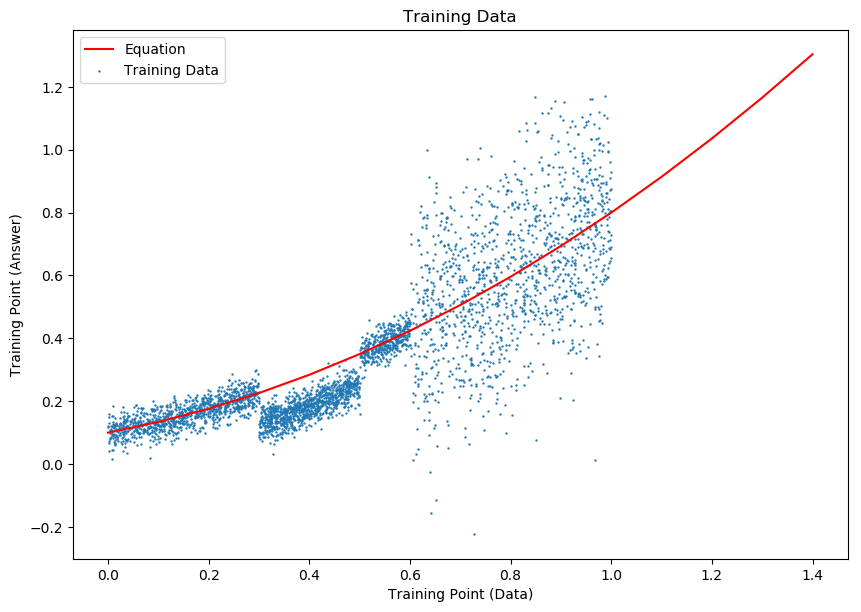

In [3]:
# Four different region, 
x_1 = np.random.uniform(0, 0.3, 1000)
x_2 = np.random.uniform(0.3, 0.5, 1000)
x_3 = np.random.uniform(0.5, 0.6, 400)
x_4 = np.random.uniform(0.6, 1, 1300)
                        
# Corresponding answer and add different noise and bias
y_1 = gen_function(x_1) + np.random.normal(0.0, 0.03, size=x_1.shape)
y_2 = gen_function(x_2) + np.random.normal(-0.1, 0.03,size=x_2.shape)
y_3 = gen_function(x_3) + np.random.normal(0.0, 0.03, size=x_3.shape)
y_4 = gen_function(x_4) + np.random.normal(0.0, 0.2, size=x_4.shape)

# Combine those 4 regions
x = np.hstack((x_1,x_2,x_3,x_4)).ravel()
y = np.hstack((y_1,y_2,y_3,y_4)).ravel()

# Array to plot the real equation lines
x_true = np.arange(0,1.5,0.1)
y_true = gen_function(x_true)

# Matlibplot
plt.figure(figsize=(10, 7), dpi=100)
plt.title('Training Data')
plt.scatter(x, y, s=0.5, label='Training Data')
plt.plot(x_true, y_true, color='red', label='Equation')
plt.xlabel('Training Point (Data)')
plt.ylabel('Training Point (Answer)')
plt.legend(loc='best')
plt.show()

# First, we will just use a very simple neural network (2 layers, 75 and 50 neurones respectively) to do the regression task without any fancy methods.

Please notice this is just for the sake of demonstartion. In real world application, please add reguarization (Validation, Early Stop, Reduce Learning Rate) and don not train 100 epochs for such simple task.
<br>

Another thing you should keep in mind neural net is a function approximation method, it will only work well with its training data domain, you can see testing data >1.0, the neural network performs poorly as it has never been trained on.

#### Remember!!! Great Power comes with Great Overfitting (2016, someone on Reddit)

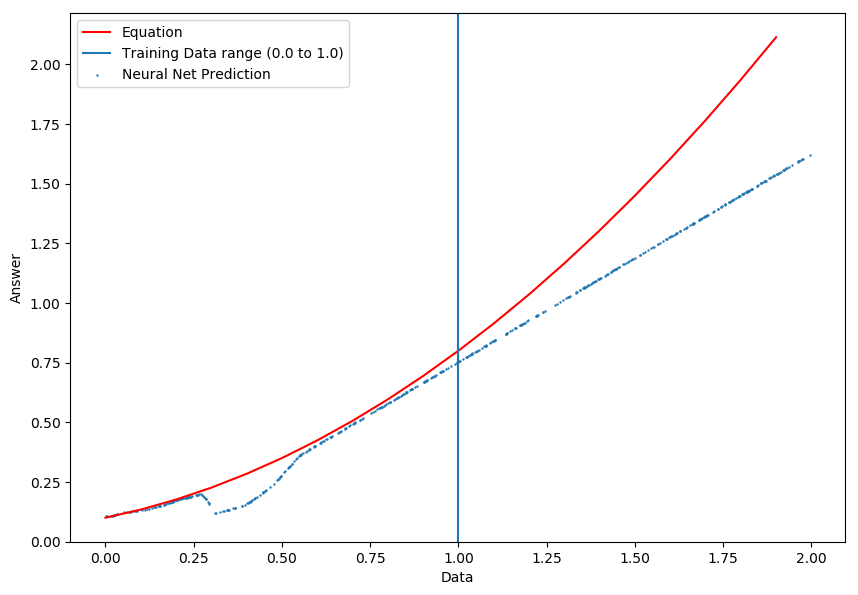

In [4]:
def model_regression(num_hidden):
    # Defeine Keras model for regression
    model = Sequential()
    model.add(InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(units=num_hidden[1], kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(units=1, activation="linear"))
    return model

#Define some parameter
optimizer = Adam(lr=.005)
batch_size = 64

# Compile Keras model
model = model_regression(num_hidden=[75,50])
model.compile(loss='mse', optimizer=optimizer) 
model.fit(x, y, validation_split=0.0, batch_size=batch_size, epochs=100, verbose=0)

# Generate test data
test_batch_size = 500
x_test = np.random.uniform(0, 2.0, test_batch_size)

# Array for the real equation
x_true = np.arange(0.0,2.0,0.1)
y_true = gen_function(x_true)

# Predict
prediction = model.predict(x_test)

# Plotting
plt.figure(figsize=(10, 7), dpi=100)
plt.scatter(x_test, prediction, s=0.5, label='Neural Net Prediction')
plt.plot(x_true, y_true, color='red', label='Equation')
plt.axvline(x=1.0, label="Training Data range (0.0 to 1.0)")
plt.xlabel('Data')
plt.ylabel('Answer')
plt.legend(loc='best')
plt.show()

# Second, we will use a 2 layered fully connected neural network with bernoulli dropout to do regression task.

I emphasize it is bernoulli dropout because Keras also provides another dropout method which is guassian dropout.

You can see the model works poorly for 'aliens' test data >1.0 because it has never been trained on that range and model uncertainty reflected this fact. But model uncertainty only depends on model, not input data, so it fails to reflect the fact that our observation is bad for data in range 0.6 to 1.0.

#### Please notice you need to apply dropout before every single weight layer (Even convolutional layers) in order for the neural network to be approximately a guassian process, and use dropout during test time.

Please refer to Yarin Gal's Blog: [What My Deep Model Doesn't Know...](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html)
 for the information why using dropout can get model uncertainty
 
Another view of this method is when we use dropout during test time, the multi-model property can be taken instead of averaging these multi-models (standard dropout method). These submodels descented to different local minimum which works well for the scope of training data, but will have different behavior outside this scope. Thats why model uncertainty will also reflects these 'alien' test data point.

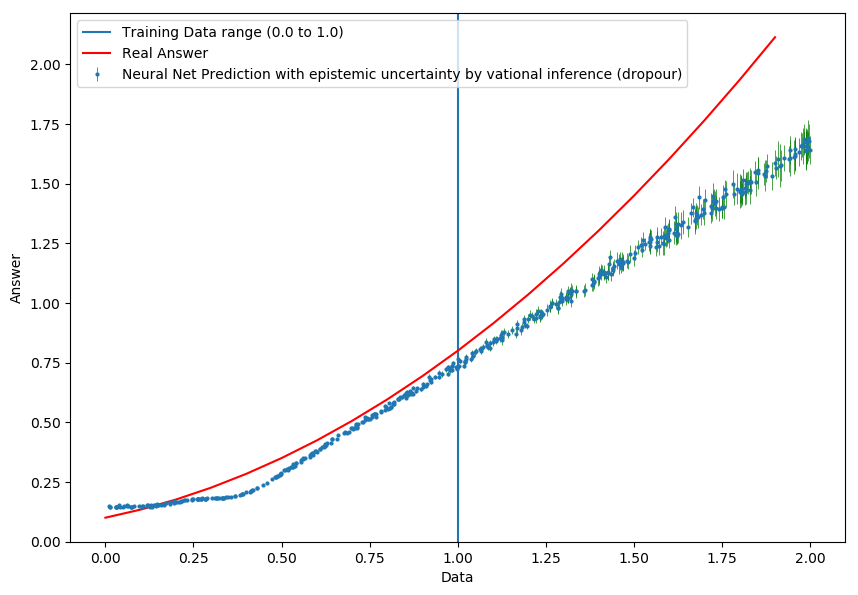

In [5]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = Sequential()
    model.add(InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], kernel_regularizer=regularizers.l2(1e-4),
                    kernel_initializer='he_normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units=num_hidden[1], kernel_regularizer=regularizers.l2(1e-4),
                    kernel_initializer='he_normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units=1, activation="linear"))
    return model

#Define some parameter
batch_size = 64
optimizer = Adam(lr=.005)

# Compile Keras model
model = model_regression_dropout(num_hidden=[100,75])
model.compile(loss='mse', optimizer=optimizer) 
model.fit(x, y, validation_split=0.0, batch_size=batch_size, epochs=20, verbose=0)

# Generate test data
test_batch_size = 500
x_test = np.random.uniform(0, 2., test_batch_size)

#Setup a Keras fucntion to use dropout vational inference in test time
get_dropout_output = function([model.layers[0].input, learning_phase()], [model.layers[-1].output])
mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    result = get_dropout_output([x_test.reshape((x_test.shape[0], 1)), 1])[0]
    predictions[i] = result

# get mean results and its varience
prediction_mc_droout = np.mean(predictions, axis=0)
var_mc_droout = np.var(predictions, axis=0)
    
# Array for the real equation
x_true = np.arange(0.0,2.0,0.1)
y_true = gen_function(x_true)

# Plotting
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(x_test, prediction_mc_droout, yerr=var_mc_droout, markersize=2, fmt='o', ecolor='g', capthick=2, elinewidth=0.5, 
             label='Neural Net Prediction with epistemic uncertainty by vational inference (dropour)')
plt.axvline(x=1.0, label="Training Data range (0.0 to 1.0)")
plt.plot(x_true, y_true, color='red', label='Real Answer')
plt.xlabel('Data')
plt.ylabel('Answer')
plt.legend(loc='best')
plt.show()

#### Dropout as  a Bayesian Approximation

Dropout is a technique that's been in use in deep learning for several years now can give us principled uncertainty estimates. Principled in the sense that the uncertainty estimates basically approximate those of our Gaussian process. Take a neural network (a recursive application of weighted linear functions followed by non-linear functions), put a probability distribution over each weight (a normal distribution for example), and with infinitely many weights you recover a Gaussian process

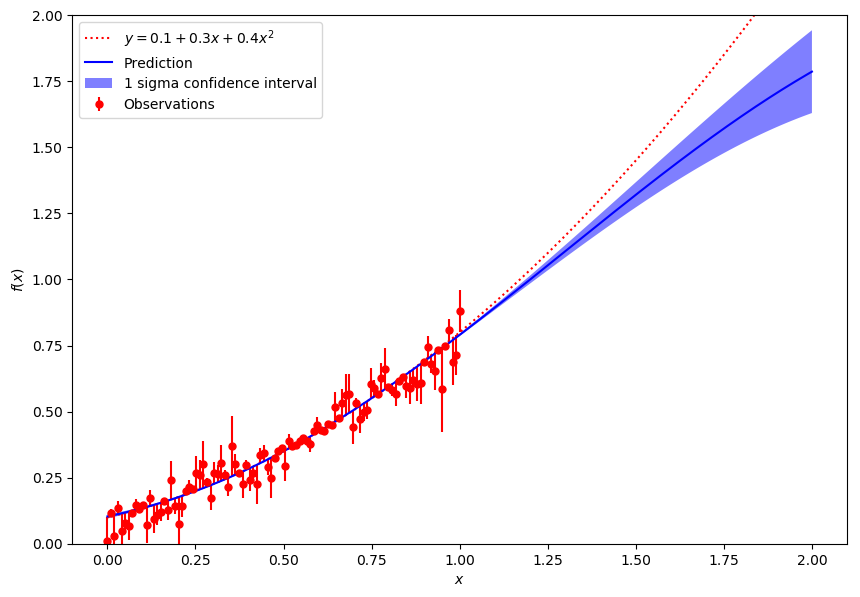

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# ----------------------------------------------------------------------
# now the noisy case
X = np.linspace(0.0, 1.0, 100)
X = np.atleast_2d(X).T

# Observations and noise
y_gp = gen_function(X).ravel()
dy = np.random.normal(0.0, 0.05, size=y_gp.shape)
y_gp += dy

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x_gp = np.atleast_2d(np.linspace(0, 2, 500)).T

# Instanciate a Gaussian Process model
kernel = C(1, (1e-3, 1e3)) * RBF(10, (1e-3, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=(dy / y_gp) ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y_gp)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x_gp, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(figsize=(10, 7), dpi=100)
plt.plot(x_gp, gen_function(x_gp), 'r:', label=u'$y=0.1+0.3x+0.4x^{2}$')
plt.errorbar(X.ravel(), y_gp, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(x_gp, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x_gp, x_gp[::-1]]),
         np.concatenate([y_pred - sigma,
                        (y_pred + sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='1 sigma confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-0, 2)
plt.legend(loc='upper left')

plt.show()

# Third, use a single model to get both epistemic and aleatoric uncertainty with variational inference

#### Please notice you need to apply dropout before every single weight layer (Even convolutional layers) in order for the neural network to be approximately a guassian process.

Please refer to the Paper: [What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?](https://arxiv.org/abs/1703.04977)
 for the information why I used what I used and the theory behind.
 
Frist we will define a "fork" model using Keras functional API, one end ouput the prediction, and the other end ouput predicted uncertainty

In [16]:
def model_regression_dropout_var(num_hidden):
    # Define Keras Model
    input_tensor = Input(batch_shape=((None, 1)))
    layer_1 = Dense(units=num_hidden[0], kernel_regularizer=regularizers.l2(1e-4),
                    kernel_initializer='he_normal', activation='relu')(input_tensor)
    layer_2 = Dropout(0.3)(layer_1)
    layer_3 = Dense(units=num_hidden[1], kernel_regularizer=regularizers.l2(1e-4),
                    kernel_initializer='he_normal', activation='relu')(layer_2)
    layer_4 = Dropout(0.3)(layer_3)

    layer2_1 = Dense(units=num_hidden[0], kernel_regularizer=regularizers.l2(1e-4),
                     kernel_initializer='he_normal', activation='relu')(input_tensor)
    layer2_2 = Dropout(0.3)(layer2_1)
    layer2_3 = Dense(units=num_hidden[1], kernel_regularizer=regularizers.l2(1e-4),
                     kernel_initializer='he_normal', activation='relu')(layer2_2)
    layer2_4 = Dropout(0.3)(layer2_3)

    # Good old output
    linear_output = Dense(units=1, activation="linear", name='linear_output')(layer_4)

    # Data-dependent uncertainty outainty
    variance_output = Dense(units=1, activation='linear', name='variance_output')(layer2_4)
    
    model = Model(inputs=input_tensor, outputs=[variance_output, linear_output])
    
    return model, linear_output

![title](model.png)

Then we will define two custom loss and custom data generator

<br>
The custom loss function for variance prediction will be<br>
$\text{Loss}=\frac{1}{T} \sum_1^T \frac{1}{2} \frac{(y-\hat{y})^{2}}{\sigma^{2}} + \frac{1}{2}\text{log}(\sigma^{2})$
<br>
<br>
But for the sake of numerical stability, its better to make the neural net to predict $\text{s} = \text{log}(\sigma^{2})$ with <br>
$\text{Loss}=\frac{1}{T} \sum_1^T \frac{1}{2} (y-\hat{y})^{2}e^{-\text{s}} + \frac{1}{2}(\text{s})$
<br>
<br>
Please notice if you use the first loss, you have to use $softplus$ as activation in the last layer as $\sigma^{2}$ is always positve, and $linear$ or other appropriate activation for second loss as $\text{log}(\sigma^{2})$ can be both positive and negative.

In [17]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

def mse_var(lin):
    def mse_var_internal(y_true, y_pred):
        return K.mean(0.5*K.square(lin-y_true)*(K.exp(-y_pred)) + 0.5*(y_pred), axis=-1)
    return mse_var_internal

def generate_train_batch(x, y):
    while True:
        indices = random.sample(range(0, x.shape[0]), batch_size)
        indices = np.sort(indices)
        x_batch, y_batch = x[indices], y[indices]
        yield (x_batch, {'linear_output': y_batch, 'variance_output': y_batch})

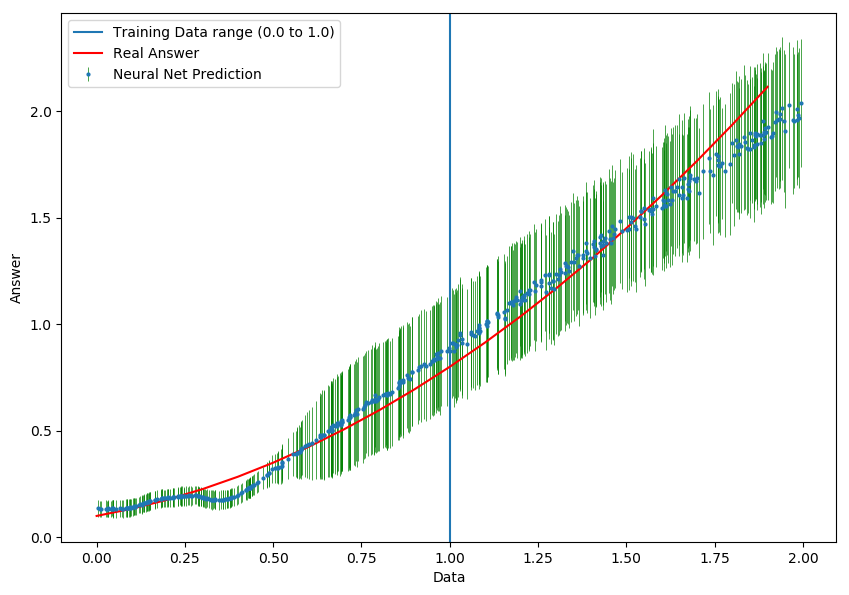

In [18]:
#Define some parameter
batch_size = 64
optimizer = Adam(lr=.005)

# Compile Keras model
num_hidden = [100,75]
model, linear_output = model_regression_dropout_var(num_hidden)
model.compile(loss={'linear_output': mean_squared_error, 'variance_output': mse_var([linear_output])}, optimizer=optimizer)
model.fit_generator(generator=generate_train_batch(x, y), epochs=20, max_queue_size=20, verbose=0, 
                    steps_per_epoch= x.shape[0] // batch_size)

# Generate test data
test_batch_size = 500
x_test = np.random.uniform(0, 2., test_batch_size)

#Setup a Keras fucntion to use dropout vational inference in test time
get_dropout_output = function([model.layers[0].input, learning_phase()], [model.get_layer('linear_output').output, 
                                                                          model.get_layer('variance_output').output])
mc_dropout_num = 100
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))
predictions_var = np.zeros((mc_dropout_num, test_batch_size, 1))
var = np.zeros((mc_dropout_num, test_batch_size, 1))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    result = np.array(get_dropout_output([x_test.reshape((x_test.shape[0], 1)), 1])[0:2])
    predictions[i] = result[0].reshape((test_batch_size,1))
    predictions_var[i] = result[1].reshape((test_batch_size,1))

# get mean results and its varience and mean unceratinty from dropout
prediction_mc_droout = np.mean(predictions, axis=0)
var = np.mean(np.exp(predictions_var/2), axis=0)
var_mc_droout = np.var(predictions, axis=0)

total_unceratinty = var+var_mc_droout  # pistemic plus aleatoric uncertainty
    
# Array for the real equation
x_true = np.arange(0.0,2.0,0.1)
y_true = gen_function(x_true)

# Plotting
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(x_test, prediction_mc_droout, yerr=total_unceratinty, markersize=2,
                     fmt='o', ecolor='g', capthick=2, elinewidth=0.5, label='Neural Net Prediction')
plt.axvline(x=1.0, label="Training Data range (0.0 to 1.0)")
plt.plot(x_true, y_true, color='red', label='Real Answer')
plt.xlabel('Data')
plt.ylabel('Answer')
plt.legend(loc='best')
plt.show()